In [1]:
import os
import numpy as np
import cv2
from ultralytics import YOLO

import matplotlib.pyplot as plt
from collections import defaultdict

from got10k.trackers import Tracker
from got10k.experiments import ExperimentGOT10k
import shutil

from utils import plotting
from utils import scores
from IPython import display

%matplotlib inline

In [2]:
data_path1 = "./datasets/GOT/val/GOT-10k_Val_000006" # Машина classes = 7
data_path2 = "./datasets/GOT/val/GOT-10k_Val_000055" # Объект сразу пропадает. classes = 1
data_path3 = "./datasets/GOT/val/GOT-10k_Val_000147" # classes = 21
classes = {
    data_path1: [7],
    data_path2: [1],
    data_path3: [21]       
}

# поменять, если требуется
data_path = data_path1
last_val_dir = data_path.split("/")[-1] 

img_names = list(filter(lambda file: file.endswith(".jpg"), os.listdir(data_path)))
img_names.sort()

In [3]:
TRACK_CONFIG = {
    "device": "0",
    "imgsz": (640, 640),
    "conf": 0.1,
    "iou": 0.4, 
    "tracker": 'bytetrack.yaml',
    "verbose": False, # Выводить в консоль inference по каждому
}

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([7.])
conf: tensor([0.7471])
data: tensor([[3.2681e+02, 2.9260e+02, 9.0866e+02, 6.1594e+02, 1.0000e+00, 7.4709e-01, 7.0000e+00]])
id: tensor([1.])
is_track: True
orig_shape: (1080, 1920)
shape: torch.Size([1, 7])
xywh: tensor([[617.7373, 454.2700, 581.8453, 323.3451]])
xywhn: tensor([[0.3217, 0.4206, 0.3030, 0.2994]])
xyxy: tensor([[326.8146, 292.5974, 908.6600, 615.9425]])
xyxyn: tensor([[0.1702, 0.2709, 0.4733, 0.5703]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([7.])
conf: tensor([0.7631])
data: tensor([[3.5840e+02, 2.5777e+02, 9.2335e+02, 6.2168e+02, 1.0000e+00, 7.6308e-01, 7.0000e+00]])
id: tensor([1.])
is_track: True
orig_shape: (1080, 1920)
shape: torch.Size([1, 7])
xywh: tensor([[640.8744, 439.7263, 564.9475, 363.9146]])
xywhn: tensor([[0.3338, 0.4072, 0.2942, 0.3370]])
xyxy: tensor([[358.4006, 257.7690, 923.3481, 621.6836]])
xyxyn: tensor([[0.1867, 0.2387, 0.4809, 0.5756]])


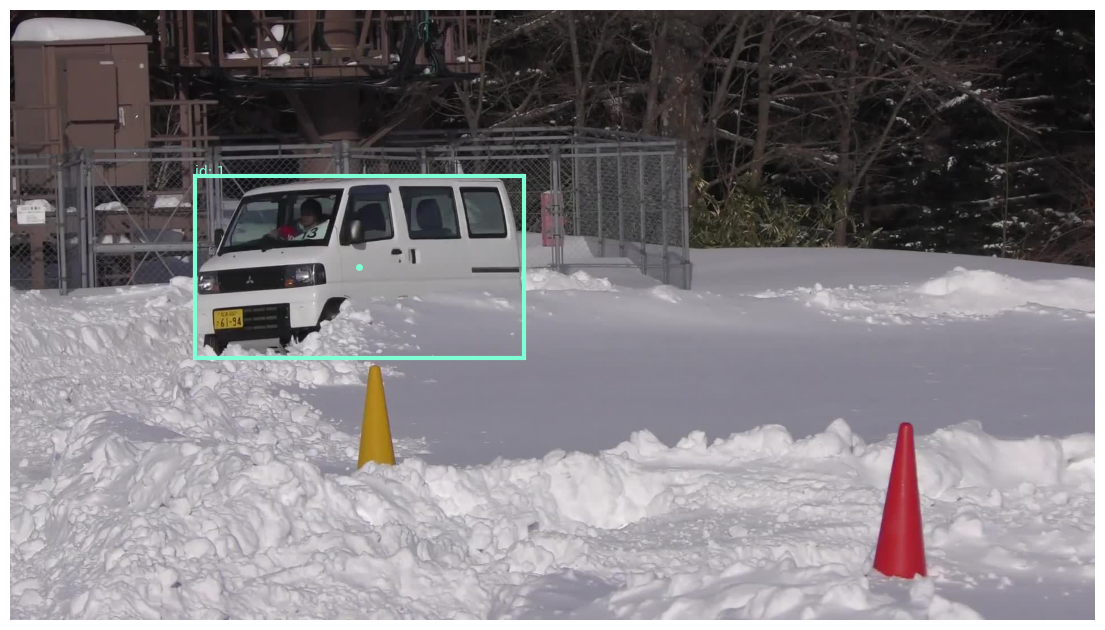

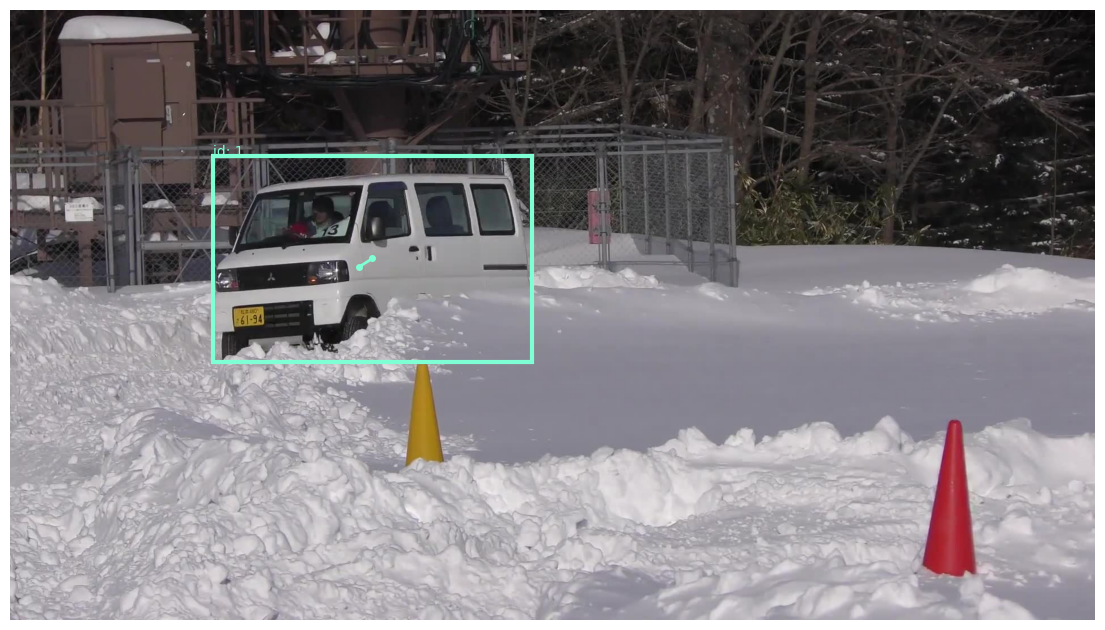

In [4]:
track_history = defaultdict(lambda: [])
model = YOLO("yolov8m.pt")
max_img = 2
processed_img = 0

for img_name in img_names[:max_img]:
    img = cv2.imread(os.path.join(data_path, img_name))
    results = model.track(img, **TRACK_CONFIG)
    print(results[0].boxes)

    # ax.clear()
    # display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))
    plotting.plot_tracks_result(img, results[0], track_history, ax = ax)
    # ax.plot()
    # display.display(fig)

In [5]:
TRACK_CONFIG = {
    "device": "0",
    "imgsz": (640, 640),
    "conf": 0.15,
    "iou": 0.4, 
    "tracker": 'bytetrack.yaml',
    "verbose": False, # Выводить в консоль inference по каждому
    "classes": classes[data_path]
}
max_img = 10
specific_id = 1
model = YOLO("yolov8m.pt")
for img_name in img_names[:max_img]:
    img = cv2.imread(os.path.join(data_path, img_name))
    result = model.track(img, **TRACK_CONFIG)[0]
    boxes = result.boxes

    x, y, w, h = 0, 0, 0, 0
    if (boxes.is_track):
        xywh_boxes = boxes.xywh.cpu()
        track_ids = boxes.id.int().cpu().tolist()

        required_track = None
        for box, track_id in zip(xywh_boxes, track_ids):
            if (track_id == specific_id):
                required_track = box
                break
        
        
        if (required_track is not None):
            x, y, w, h = required_track
            x = x - w // 2
            y = y - h // 2

    if (w + h == 0):
        # Изображения, где пропал трек id
        plotting.plot_detection_result(result)


In [6]:
class IdentityTracker(Tracker):
    def __init__(self, model, model_config, target_id):
        super(IdentityTracker, self).__init__(
            name=model_config["tracker"], 
            is_deterministic=True   
        )
        self.model = model
        self.specific_id = target_id
        self.config = model_config
    
    def init(self, image, box):
        # Остается идентичным, т.к. для MOT никак не инициализируем по bbox 
        self.model.track(image, **self.config)
        self.box = box

    def update(self, image):
        result = self.model.track(image, **self.config)[0]
        boxes = result.boxes
        x, y, w, h = 0, 0, 0, 0
        if (boxes.is_track):
            xywh_boxes = boxes.xywh.cpu()
            track_ids = boxes.id.int().cpu().tolist()

            estiamated_track = None
            for box, track_id in zip(xywh_boxes, track_ids):
                if (track_id == self.specific_id):
                    estiamated_track = box
                    break
            
            if (estiamated_track is not None):
                x, y, w, h = estiamated_track
                x = x - w // 2
                y = y - h // 2
        return np.array([x, y, w, h], dtype=np.int64)

In [7]:
## ДАЛЕЕ ЕСТЬ ТРЕБУЕТСЯ ЗАПУСТИТЬ ТЕСТ ТОЛЬКО ДЛЯ ОДНОЙ ВЫБОРКИ или ее изменить, ТО НУЖНО:
## datasets/GOT/vallist.txt добавить / удалить NAME_DIR тестовой выборки
f = open("./datasets/GOT/val/list.txt", "w")
f.write(last_val_dir)
f.close()

In [8]:
TRACK_CONFIG = {
    "device": "0",
    "imgsz": (640, 640),
    "conf": 0.1,
    "iou": 0.4, 
    "tracker": 'bytetrack.yaml',
    "verbose": False, # Выводить в консоль inference по каждому
    "classes": classes[data_path]
}
model = YOLO("yolov8m.pt")

tracker = IdentityTracker(model, TRACK_CONFIG, 1)
experiment = ExperimentGOT10k(
        root_dir="./datasets/GOT",  # GOT-10k's root directory
        subset='val',               # 'train' | 'val' | 'test'
        result_dir='sot_tracking_results',       # where to store tracking results
        report_dir='reports'        # where to store evaluation reports
    )

Running tracker bytetrack.yaml on GOT-10k...
--Sequence 1/1: GOT-10k_Val_000006
 Repetition: 1
  Results recorded at sot_tracking_results\GOT-10k\bytetrack.yaml\GOT-10k_Val_000006\GOT-10k_Val_000006_001.txt
Evaluating bytetrack.yaml
Saving success plots to reports\GOT-10k\bytetrack.yaml\success_plot.png


{'bytetrack.yaml': {'overall': {'ao': 0.9254264588038097,
   'sr': 0.9746835443037974,
   'speed_fps': 12.097254391893442,
   'succ_curve': [0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,

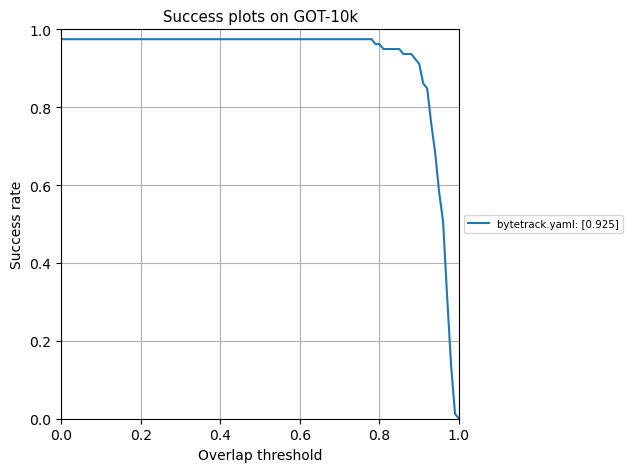

In [9]:
# Подчищаем предыдущие
tracker_name = TRACK_CONFIG["tracker"]
RESULTS_DIR = f"./sot_tracking_results/GOT-10k/{tracker_name}"
REPORT_DIR = f"./reports/GOT-10k/{tracker_name}"
try:
    shutil.rmtree(RESULTS_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))
try:
    shutil.rmtree(REPORT_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

experiment.run(tracker, visualize=False)
experiment.report([tracker.name])

In [10]:
TRACK_CONFIG = {
    "device": "0",
    "imgsz": (640, 640),
    "conf": 0.1,
    "iou": 0.4, 
    "tracker": 'botsort.yaml',
    "verbose": False, # Выводить в консоль inference по каждому
    "classes": classes[data_path]
}
model = YOLO("yolov8m.pt")
tracker = IdentityTracker(model, TRACK_CONFIG, 1)

experiment = ExperimentGOT10k(
        root_dir="./datasets/GOT",  # GOT-10k's root directory
        subset='val',               # 'train' | 'val' | 'test'
        result_dir='sot_tracking_results',       # where to store tracking results
        report_dir='reports'        # where to store evaluation reports
    )

Running tracker botsort.yaml on GOT-10k...
--Sequence 1/1: GOT-10k_Val_000006
 Repetition: 1
  Results recorded at sot_tracking_results\GOT-10k\botsort.yaml\GOT-10k_Val_000006\GOT-10k_Val_000006_001.txt
Evaluating botsort.yaml
Saving success plots to reports\GOT-10k\botsort.yaml\success_plot.png


{'botsort.yaml': {'overall': {'ao': 0.9254264588038097,
   'sr': 0.9746835443037974,
   'speed_fps': 8.96550276878194,
   'succ_curve': [0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
    0.9746835443037974,
   

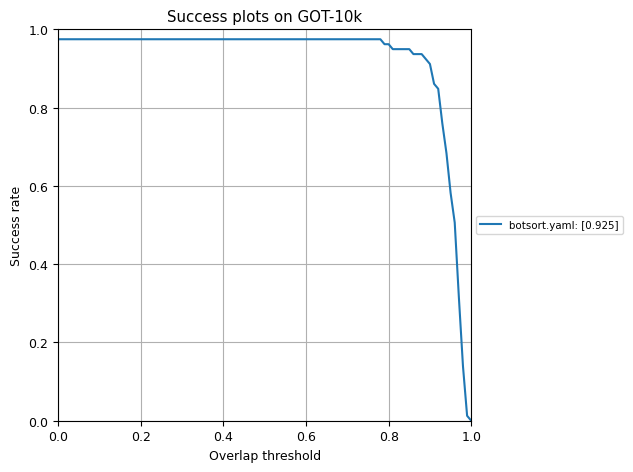

In [11]:
# Подчищаем предыдущие
tracker_name = TRACK_CONFIG["tracker"]
RESULTS_DIR = f"./sot_tracking_results/GOT-10k/{tracker_name}"
REPORT_DIR = f"./reports/GOT-10k/{tracker_name}"
try:
    shutil.rmtree(RESULTS_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))
try:
    shutil.rmtree(REPORT_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


experiment.run(tracker, visualize=False)
experiment.report([tracker.name])

In [12]:
#bot_sort
scores.get_scores(f"./datasets/GOT/val/{last_val_dir}/groundtruth.txt", f"sot_tracking_results/GOT-10k/botsort.yaml/{last_val_dir}/{last_val_dir}_001.txt")

--- Evaluate for GOT-10k ---
Average Overlap (AO): 92.64 %
Success 0.5 (SR0.5): 97.50 %
Success 0.75 (SR0.75): 97.50 %
--- Evaluate for TrackingNet & LaSOT ---
Success score (AUC): 90.54 %
Precision score (P): 93.75 %
NPrecision score (P_norm): 93.50 %


In [13]:
#byte_track
scores.get_scores(f"./datasets/GOT/val/{last_val_dir}/groundtruth.txt", f"sot_tracking_results/GOT-10k/bytetrack.yaml/{last_val_dir}/{last_val_dir}_001.txt")

--- Evaluate for GOT-10k ---
Average Overlap (AO): 92.64 %
Success 0.5 (SR0.5): 97.50 %
Success 0.75 (SR0.75): 97.50 %
--- Evaluate for TrackingNet & LaSOT ---
Success score (AUC): 90.54 %
Precision score (P): 93.75 %
NPrecision score (P_norm): 93.50 %


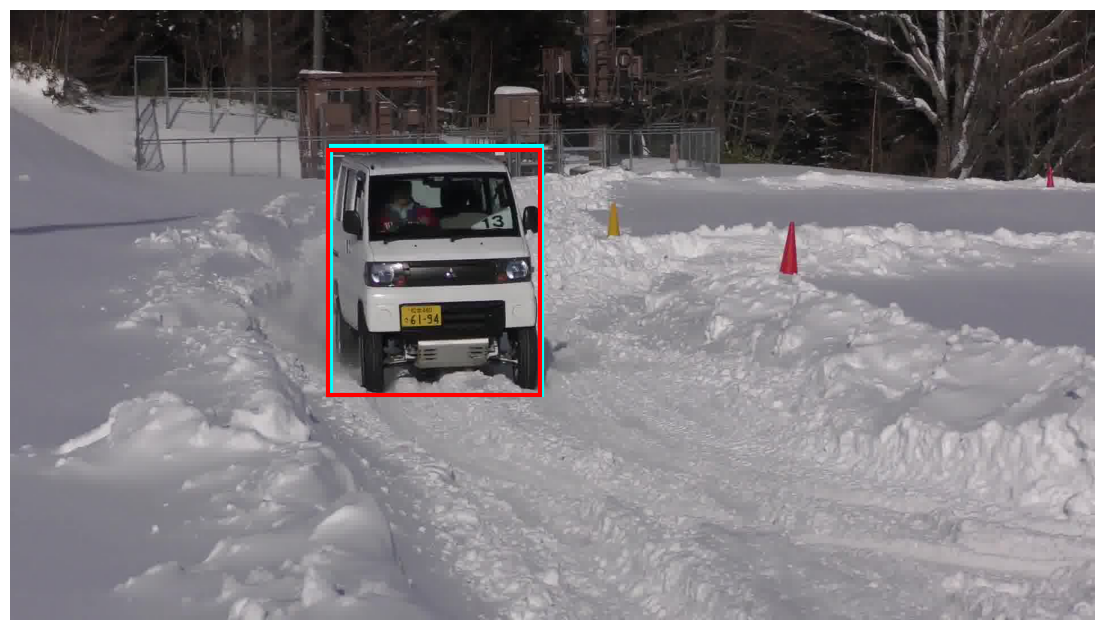

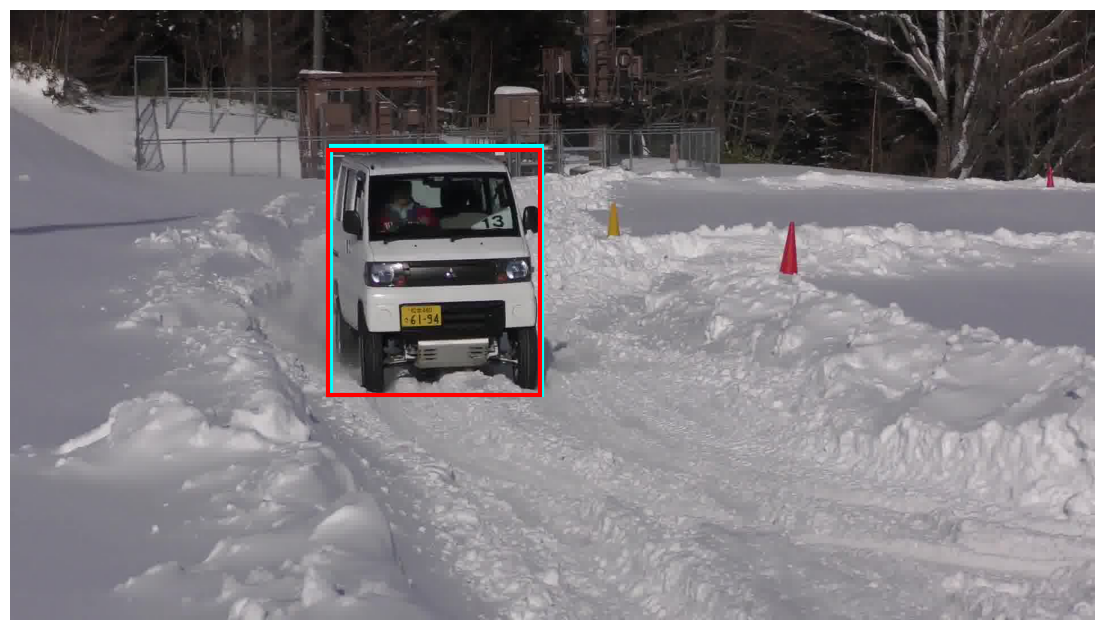

In [14]:
TRACK_CONFIG = {
    "device": "0",
    "imgsz": (640, 640),
    "conf": 0.15,
    "iou": 0.4, 
    "tracker": 'bytetrack.yaml',
    "verbose": False, # Выводить в консоль inference по каждому
    "classes": classes[data_path]
}

specific_id = 1

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

gt_boxes = np.loadtxt(data_path + "/groundtruth.txt", delimiter=',')
for img_name, gt_box in zip(img_names, gt_boxes):
    img = cv2.imread(os.path.join(data_path, img_name))
    result = model.track(img, **TRACK_CONFIG)[0]
    boxes = result.boxes

    if (boxes.is_track):
        xywh_boxes = boxes.xywh.cpu()
        track_ids = boxes.id.int().cpu().tolist()

        required_track = None
        for box, track_id in zip(xywh_boxes, track_ids):
            if (track_id == specific_id):
                required_track = box
                break
        
        
        if (required_track is not None):
            x, y, w, h = required_track
            x = x - w // 2
            y = y - h // 2


    ax.clear()
    display.clear_output(wait=True)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    if (w + h != 0):
        plotting.add_obj_bbox_to_plot(ax, np.array([x, y, w, h], dtype=np.int64), plotting.COLOURS[0], centered=False)
    
    plotting.add_obj_bbox_to_plot(ax, np.array(gt_box, dtype=np.int64), "red", centered=False)

    ax.axis('off')
    ax.plot()
    display.display(fig)
    